<a href="https://colab.research.google.com/github/ajm2327/LSTM_Price_Prediction/blob/ajm2327-patch-1/LSTM_Price_Prediction_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
#have to install pandas_ta fist
!pip install pandas_ta

#import required libraries
#######################################################################################
#THESE LIBRARIES ARE FOR INITIAL DATA PREPARATION
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta
#FOR SCALING THE DATA
from sklearn.preprocessing import MinMaxScaler
import joblib
#FOR TRAINING THE LSTM MODEL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#set random seed for reproducibility
np.random.seed(42)
########################################################################################

######------THIS FUNCTION IS FOR GETTING 10 YEARS OF STOCK DATA----------#############
def get_ticker_data(TICKER, START_DATE = '2014-08-01', END_DATE = '2024-08-01'):

  #Download stock data
  try:
    data = yf.download(TICKER, start=START_DATE, end=END_DATE)

    #check if data is empty
    if data.empty:
      raise ValueError(f"No data found for {TICKER} from {START_DATE} to {END_DATE}")

    #display first ten rows of the data
    print(data.tail(10))

    #display basic stats:
    print("\nBasic Statistics:")
    print(data.describe())
    print("Dataset length:", len(data))

    #plot closing prices
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['Close'])
    plt.title(f'{TICKER} Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.show()

    return data

  except Exception as e:
    print(f"Error: {e}")


#############--------------ADDING INDICATOR SET-----------------###############
def add_indicators(data, indicator_set='default'):
  """
  Add technical indicators to the dataset.

  Args:
  data (pd.DataFrame): Input dataframe with OHLCV data
  indicator_set(str): 'default' or 'alternative'

  Returns:
  pd.DataFrame: Dataframe with added indicators
  """

  if indicator_set == 'default':
    #default indicator set
    data['RSI'] = ta.rsi(data.Close, length = 15)
    data['EMAF'] = ta.ema(data.Close, length = 20)
    #data['EMAM'] = ta.ema(data.Close, length = 100)
    #data['EMAS'] = ta.ema(data.Close, length = 150)
    #the commented out indicators above had little impact on the model's performance,
    #I am adding bollinger bands instead to see if these will provide any benefit
    bb = ta.bbands(data.Close, length = 20)
    data = pd.concat([data, bb], axis = 1)

    #let's go ahead and just give it more indicators:
    data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
    data['Signal'] = ta.macd(data['Close'])['MACDs_12_26_9']
    data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'])
    data['OBV'] = ta.obv(data['Close'], data['Volume'])


  elif indicator_set == 'alternative':
    #alternate indicator set

    data['EMA'] = ta.ema(data.Close, length = 50)
    data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume)

  else:
    raise ValueError("Invalid indicator set. Use 'default' or 'alternative'.")

  return data

###########-------------CREATE TARGET COLUMN-------------------################
def prepare_target(data):
  """
  Prepare target variables for the LSTM model

  Args:
  data (pd.DataFrame): Input dataframe with OHLCV data

  Returns:
  pd.DataFrame: Dataframe with target variables
  """
  # Next day's price movement
  data['Target'] = data['Adj Close'] - data.Open
  data['Target'] = data['Target'].shift(-1)

  #Binary classification target
  data['TargetClass'] = (data['Target'] > 0).astype(int)

  #next day's closing price
  data['TargetNextClose'] = data['Adj Close'].shift(-1)

  return data

###########-------DROP UNNECESSARY COLUMNS, RESET INDEX--------------###########
def clean_data(data, columns_to_drop = ['Volume', 'Close', 'Date']):
  """
  Clean the dataset by dropping NaN values and specified columns

  Args:
  data (pd.DataFrame): Input dataframe
  columns_to_drop (list): List of columns to drop

  Returns:
  pd.DataFrame: Cleaned dataframe
  """
  data.dropna(inplace = True)
  print('CLEANING dropna: dataset length: ', len(data))

  data.reset_index(inplace = True)
  print('CLEANING rst idx: dataset length: ', len(data))

  data.drop(columns_to_drop, axis = 1, inplace = True)
  print('CLEANING drop col: dataset length: ', len(data))


  return data


#############----------SCALE DATA TO RANGE OF 0 TO 1-----------------################
def scale_data(data, feature_range = (0,1), save_scaler = True, scaler_path = 'scaler.pkl'):
  """
  Prepare the dataset by handling non-numeric columns first

  Scale the dataset using MinMaxScaler

  Args:
  data (pd.DataFrame or np.array): Input data to be scaled
  feature_range (tuple): Range to scale the data to (default: (0,1))
  save_scaler (bool): Whether to save the scaler object (default: True)
  scaler_path (str): Path to save the scaler object (default: 'scaler.pkl)

  Returns:
  np.array: Scaled Dataset
  MinMaxScaler: Fitted Scaler Object
  """

  numeric_columns = data.select_dtypes(include = [np.number]).columns
  non_numeric_columns = data.select_dtypes(exclude = [np.number]).columns

  if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns found: {non_numeric_columns}")
    print("These columns will be dropped for scaling.")

  #select only numeric columns for scaling
  data_numeric = data[numeric_columns]

  #initialize MinMaxScaler
  scaler = MinMaxScaler(feature_range = feature_range)

  """
  #check if input is a dataframe, if so, convert to np array
  if isinstance(data, pd.DataFrame):
    data_array = data.values
  else:
    data_array = data
  """

  #fit and transform the data
  data_scaled = scaler.fit_transform(data)

  #save the scaler for later use (like inverse scaling)
  if save_scaler:
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")

  return data_scaled, scaler


##########----------------PREPARE LSTM DATA------------------#####################
def prepare_lstm_data(data_set_scaled, backcandles = 30, target_column = -1, feature_columns = None):

  """
  Prepare data for LSTM model by creating sequences of historical data.

  Args:
  data_set_scaled (np.array): Scaled input data
  backcandles (int): Number of historical time steps to use for each sample
  target_column (int): Index of the target column (-1 for last column)
  feature_columns (list): Number of columns to use as features (N)

  Returns:
  tuple: X (input sequences), y (target values)
  """

  X = []
  print(data_set_scaled.shape[0])
  for j in feature_columns:
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
      X[j].append(data_set_scaled[i-backcandles:i, j])

  #Move axis from 0 to position 2
  X = np.moveaxis(X, [0], [2])
  #Extract target values
  y = data_set_scaled[backcandles:, target_column]

  return np.array(X), np.array(y).reshape(-1,1)



##############------------TRAIN LSTM----------------------######################
def create_and_train_lstm(X_train, y_train, backcandles = 30, features = 9, lstm_units = 150, batch_size = 15, epochs = 30, validation_split = 0.1, patience = 15):
  """
  Creates and trains lstm model

  Args:
  X_train(np.ndarray): Training input data with shape (samples, backcandles, features)
  y_train(np.ndarray): training target data
  backcandles(int): Number of time steps to look back (default = 30)
  features(int): Number of input features (default = 9)
  lstm_units(int): Number of units in LSTM layer (default = 150)
  batch_size(int): Batch size for training (default = 15)
  epochs(int): Number of epochs for training (default = 30)
  validation_split(float): fraction of training data to use for validation (default = 0.1)

  Returns:
  keras.Model: trained LSTM keras model

  """
  np.random.seed(42)
  tf.random.set_seed(42)

  lstm_input = layers.Input(shape=(backcandles, features), name='lstm_input')
  inputs = layers.LSTM(lstm_units, name='first_layer')(lstm_input)
  inputs = layers.Dense(128)(inputs)
  inputs = layers.Dense(1, name='dense_layer')(inputs)
  #inputs = layers.Dropout(0.001)(inputs) #Dropout for regulation
  output = layers.Activation('linear', name='output')(inputs)
  model = models.Model(inputs=lstm_input, outputs=output)


  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer=adam, loss='mse')

  early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)
  model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only = True, monitor = 'val_loss')

  history = model.fit(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_split = validation_split,
      callbacks = [early_stopping, model_checkpoint])

  model.summary()

  return model, history

#PREPARE DATA

In [3]:
def prepare_data(TICKER = 'SPY', START_DATE = '2014-08-01', END_DATE = '2024-08-01',
                 indicator_set = 'default', verbose = True):
  #Get ticker data:
  data = get_ticker_data(TICKER, START_DATE, END_DATE)

  if verbose:
    print('Dataset length before cleaning: ', len(data))

  data = add_indicators(data, indicator_set)

  data = prepare_target(data)
  data = clean_data(data)

  if verbose:
    print('Dataset length after cleaning: ', len(data))
    print(data.tail(20))
    print('--------------------------------------------------------------------')


  #Scale the data
  feature_range = (0,1) #adjustable
  save_scaler = True #adjustable
  scaler_path = 'lstm_scaler.pkl' #adjustable

  data_set_scaled, scaler = scale_data(data, feature_range, save_scaler, scaler_path)

  if verbose:
    print("SCALED DATA SHAPE:", data_set_scaled.shape)
    print("\nFirst few rows of scaled data:")
    print(data_set_scaled[:5])

    print("\nSCALING RANGES:")
    for i, column in enumerate(data.columns):
      print(f"{column}: {data_set_scaled[:,i].min():.4f} to {data_set_scaled[:,i].max():.4f}")

  return data_set_scaled


#TRAIN LSTM: BASICALLY THE MAIN FUNCTION

[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-04  550.200012  554.429993  549.460022  550.950012  550.950012   
2024-09-05  550.890015  553.799988  547.099976  549.609985  549.609985   
2024-09-06  549.940002  551.599976  539.440002  540.359985  540.359985   
2024-09-09  544.650024  547.710022  542.679993  546.409973  546.409973   
2024-09-10  548.359985  549.150024  543.380005  548.789978  548.789978   
2024-09-11  548.700012  555.359985  539.960022  554.419983  554.419983   
2024-09-12  555.010010  559.400024  552.739990  559.090027  559.090027   
2024-09-13  559.710022  563.030029  559.450012  562.010010  562.010010   
2024-09-16  561.739990  563.109985  559.900024  562.840027  562.840027   
2024-09-17  565.099976  566.580017  560.789978  563.070007  563.070007   

              Volume  
Date                  
2024-09-04  47224900  
2024-09-05  44264300  
2024-09-06  6849380

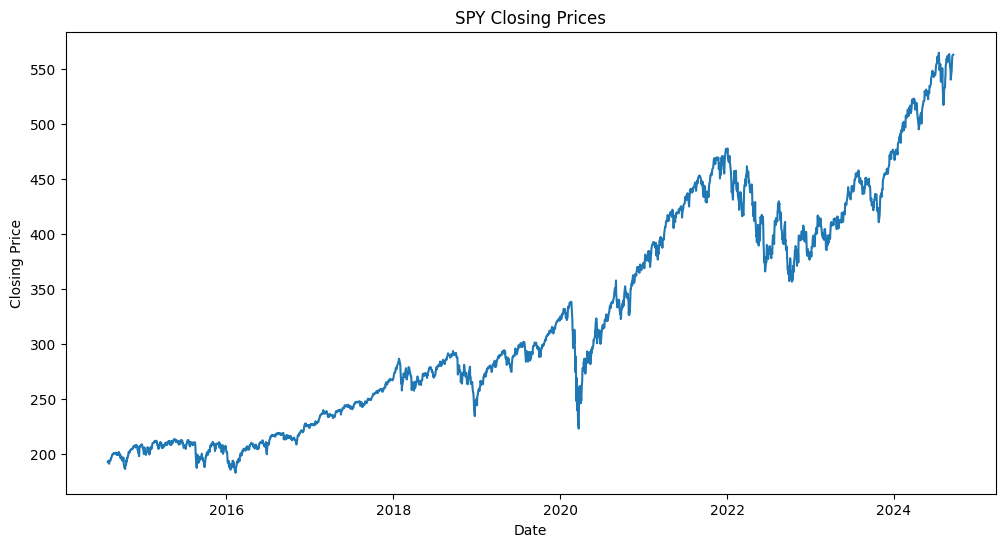

Dataset length before cleaning:  2549
CLEANING dropna: dataset length:  2515
CLEANING rst idx: dataset length:  2515
CLEANING drop col: dataset length:  2515
Dataset length after cleaning:  2515
            Open        High         Low   Adj Close        RSI        EMAF  \
2495  554.729980  559.609985  553.859985  559.609985  61.808840  543.137086   
2496  559.150024  560.840027  557.330017  558.700012  61.022431  544.619270   
2497  559.770020  562.109985  554.729980  560.619995  62.112188  546.143148   
2498  562.559998  563.179993  554.979980  556.219971  58.122146  547.102846   
2499  559.530029  563.090027  557.289978  562.130005  61.666053  548.534004   
2500  563.179993  563.909973  559.049988  560.789978  60.423848  549.701239   
2501  559.489990  562.059998  558.320007  561.559998  60.908666  550.830645   
2502  561.210022  561.650024  555.039978  558.299988  57.702261  551.542011   
2503  560.309998  563.679993  557.179993  558.349976  57.738811  552.190388   
2504  560.77002

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 7, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 100)                 │          46,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,373 (696.77 KB)

 Trainable params: 59,457 (232.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 118,916 (464.52 KB)

In [79]:
#DEFINE VARIABLES
TICKER = 'SPY'
START_DATE = '2014-08-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')
#scaler usage
backcandles = 7 #also used for training function
target_column = -1 #last column
feature_columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#Training Usage
features = len(feature_columns)
lstm_units = 100
batch_size = 12
epochs = 300
validation_split = 0.1
patience = 20
#Prepare data
data_set_scaled = prepare_data(TICKER, START_DATE, END_DATE)
X, y = prepare_lstm_data(data_set_scaled, backcandles, target_column, feature_columns)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

print("\nSample input sequence:")
print(X[0])
print("\nCorresponding target value:")
print(y[0])
print('\n-----------------------------------------------------------------------------\n')
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

print('\n-----------------------------------------------------------------------------\n')
#TRAIN THE MODEL
model, history = create_and_train_lstm(X_train, y_train, backcandles, features, lstm_units, batch_size, epochs, validation_split, patience)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
test size: 502


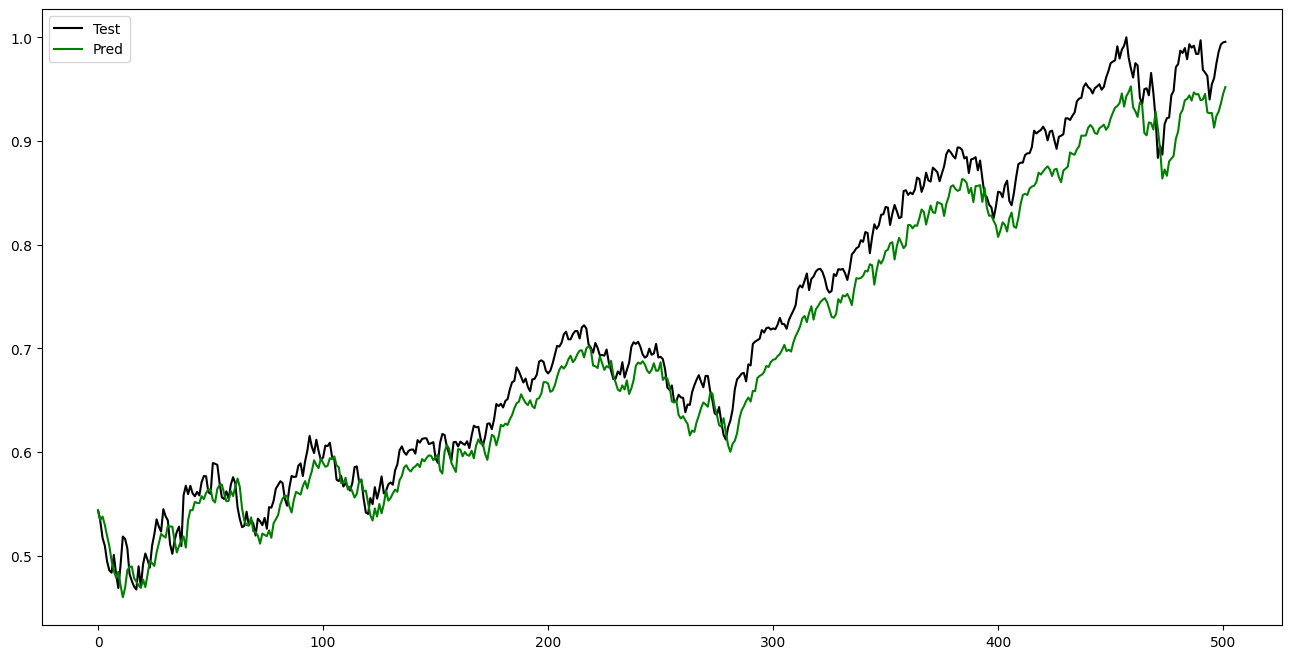

In [80]:
y_predict = model.predict(X_test)
print('test size:', len(y_predict))
#for i in range(len(y_predict)):
  #  print(y_predict[i], y_test[i])

plt.figure(figsize = (16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_predict, color = 'green', label = 'Pred')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

original dataset length: 2549
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-11  548.700012  555.359985  539.960022  554.419983  554.419983   
2024-09-12  555.010010  559.400024  552.739990  559.090027  559.090027   
2024-09-13  559.710022  563.030029  559.450012  562.010010  562.010010   
2024-09-16  561.739990  563.109985  559.900024  562.840027  562.840027   
2024-09-17  565.099976  566.580017  560.789978  563.070007  563.070007   

              Volume  
Date                  
2024-09-11  75248600  
2024-09-12  51892700  
2024-09-13  39310500  
2024-09-16  36656100  
2024-09-17  49233400  
Cleaned dataset length: 2549
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-04  550.200012  554.429993  549.460022  550.950012  550.950012   
2024-09-05  550.890015  553.799988  547

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FORECASTING FUTURE PRICES:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
forecasted prices 7
forecasted dates 7


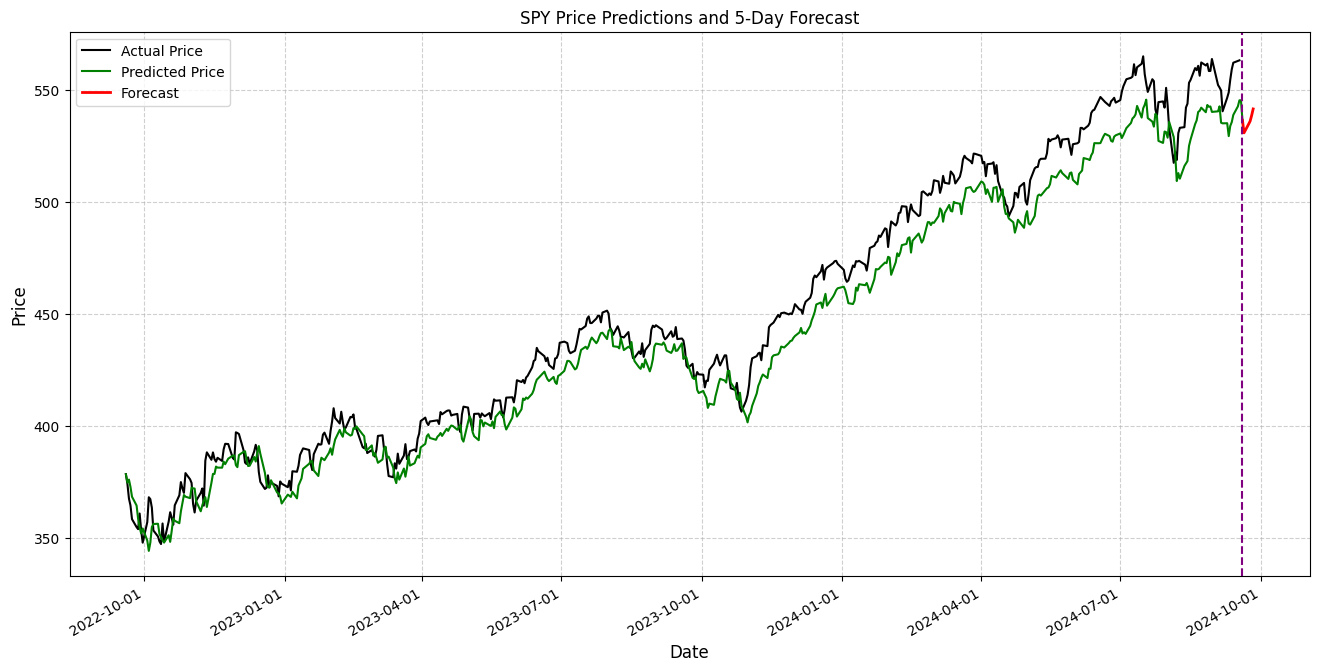

FIRST FEW PREDICTIONS
        Date  Predicted Price  Actual Price
0 2022-09-19       378.509031    378.582062
1 2022-09-20       374.799957    374.236481
2 2022-09-21       376.146141    367.708405
3 2022-09-22       372.871318    364.619720
4 2022-09-23       368.509445    358.510590

LAST FEW PREDICTIONS WITH NEXT DAY
          Date  Predicted Price  Actual Price
499 2024-09-13       538.745760    562.010010
500 2024-09-16       542.548341    562.840027
501 2024-09-17       545.247278    563.070007
0   2024-09-18       545.247351           NaN
1   2024-09-19       536.329267           NaN
2   2024-09-20       530.747834           NaN
3   2024-09-23       534.588373           NaN
4   2024-09-24       535.924945           NaN
5   2024-09-25       538.481881           NaN
6   2024-09-26       541.405961           NaN


In [90]:
#---------------------------------------------------------------------------
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#---------------------------------------------------------------------------

def inverse_transform_predictions(scaler, scaled_predictions, feature_index):
  """
  Inverses transform the scaled predictions back to original scale

  Args:
  scaler (MinMaxScaler): The fitted scaler object
  scaled_predictions (np.array): The scaled predictions
  feature_index (int): The index of the feature to inverse transform

  Returns:
  np.array: The inverse transformed predictions

  """

  #Create a dummy array with the same shape as the training data
  dummy_array = np.zeros((len(scaled_predictions), scaler.n_features_in_))

  #put the predictions into the correct column
  dummy_array[:, feature_index] = scaled_predictions.flatten()

  #inverse transform
  return scaler.inverse_transform(dummy_array)[:, feature_index]

# Function to get the next trading day
def next_trading_day(date, holidays):
    next_day = date + pd.Timedelta(days=1)
    while next_day.weekday() >= 5 or next_day in holidays:
        next_day += pd.Timedelta(days=1)
    return next_day



# Update the next_day variable in the get_price_predictions function
def get_price_predictions(model, X_test, scaler, original_data, backcandles, target_column_index, forecast_days=5):
    """
    Get price predictions with corresponding dates.

    Args:
    model (keras.Model): The trained LSTM model
    X_test (np.array): The test input data
    scaler (MinMaxScaler): The fitted scaler object
    original_data (pd.DataFrame): The original dataframe with dates
    backcandles (int): The number of historical candles used for each prediction
    target_column_index (int): The index of the target column in the original dataset

    Returns:
    pd.DataFrame: A dataframe with dates and predicted prices
    """
    # Make predictions
    print('PREDICTING TEST SET:')
    y_predict_scaled = model.predict(X_test)

    # Inverse transform predictions
    y_predict = inverse_transform_predictions(scaler, y_predict_scaled, target_column_index)

    # Get the dates for the test set
    test_dates = original_data.index[-len(X_test):]

    # Create a dataframe with dates and predictions
    predictions_df = pd.DataFrame({
        'Date': test_dates,
        'Predicted Price': y_predict.flatten(),
        'Actual Price': original_data['Adj Close'].values[-len(X_test):]
    })
    print('FORECASTING FUTURE PRICES:')

    # Create a holiday calendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=original_data.index.min(), end=original_data.index.max() + pd.Timedelta(days=30))

    last_sequence = X_test[-1:].reshape(1, backcandles, -1)

    forecast_dates = []
    forecast_prices = []

    for _ in range(forecast_days):
      #predict the next day
      next_day_scaled = model.predict(last_sequence)
      next_day_price = inverse_transform_predictions(scaler, next_day_scaled, target_column_index)

      #get next trading day
      if not forecast_dates:
        last_date = original_data.index[-1]
      else:
        last_date = forecast_dates[-1]
      next_trading_date = next_trading_day(last_date, holidays)

      forecast_dates.append(next_trading_date)
      forecast_prices.append(next_day_price[0])

      #update last sequence for the next prediction
      last_sequence = np.roll(last_sequence, -1, axis =1)
      last_sequence[0,-1,target_column_index] = next_day_scaled[0,0]

    print("forecasted prices", len(forecast_prices))
    print("forecasted dates", len(forecast_dates))
    # Add forecasted days to the predictions dataframe
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Predicted Price': forecast_prices,
        'Actual Price': [np.nan] * forecast_days #placeholder for unknown actual price
    })

    # Concatenate the predictions with the next day prediction
    predictions_df = pd.concat([predictions_df, forecast_df])

    return predictions_df



#----------------------------------------------------------------------------------
# Load the original data again
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
print("original dataset length:", len(data))
print(data.tail(5))

#remove rows with Nan values but keep the last row
data_cleaned = data.dropna().iloc[:-1]
last_row = data.iloc[-1:]
data_cleaned = pd.concat([data_cleaned, last_row])

print("Cleaned dataset length:", len(data_cleaned))
print(data_cleaned.tail(10))

# Load the saved scaler
scaler = joblib.load('lstm_scaler.pkl')

# Get price predictions
predictions_df = get_price_predictions(model, X_test, scaler, data, backcandles, target_column_index=-1, forecast_days = 7)

plt.figure(figsize=(16, 8))

# Plot actual prices
plt.plot(predictions_df['Date'][:-5], predictions_df['Actual Price'][:-5],
         color='black', label='Actual Price')

# Plot predicted prices (excluding forecast)
plt.plot(predictions_df['Date'][:-5], predictions_df['Predicted Price'][:-5],
         color='green', label='Predicted Price')

# Plot forecasted prices
plt.plot(predictions_df['Date'][-6:], predictions_df['Predicted Price'][-6:],
         color='red', label='Forecast', linewidth=2)

plt.title(f'{TICKER} Price Predictions and 5-Day Forecast')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(True, linestyle='--', alpha=0.6)

# Add vertical line to separate historical data from forecast
last_historical_date = predictions_df['Date'].iloc[-6]
plt.axvline(x=last_historical_date, color='purple', linestyle='--', label='Forecast Start')

plt.show()
# Print the first few predictions
print('FIRST FEW PREDICTIONS')
print(predictions_df.head())
print('\nLAST FEW PREDICTIONS WITH NEXT DAY')
# Print the last few predictions
print(predictions_df.tail(10))

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, set_name=""):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"{set_name} Metrics:")
  print(f"MSE: {mse:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"R^2 score: {r2:.4f}\n")

#metrics for training set
y_train_pred = model.predict(X_train)
calculate_metrics(y_train, y_train_pred, "Training")
#metrics for test set:
y_test_pred = model.predict(X_test)
calculate_metrics(y_test, y_test_pred, "Test")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training Metrics:
MSE: 0.0001
RMSE: 0.0120
MAE: 0.0086
R^2 score: 0.9967

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Metrics:
MSE: 0.0009
RMSE: 0.0295
MAE: 0.0253
R^2 score: 0.9604



#Implementing Monte Carlo Predictions

In [ ]:
import numpy as np

def monte_carlo_prediction(model, last_sequence, scaler, n_simulations, n_steps, target_column_index):
  simulations = []
  for _ in range (n_simulations):
    current_sequence = last_sequence.copy()
    path = []
    for _ in range(n_steps):
      prediction = model.predict(current_sequence)
      path.append(prediction[0,0])
      current_sequence = np.roll(current_sequence, -1, axis = 1)
      current_sequence[0,-1,0] = prediction
    simulations.append(path)

  simulations = np.array(simulations)
  mean_path = np.mean(simulations, axis = 0)

  mean_path_original = inverse_transform_predictions(scaler, mean_path, target_column_index)

  return mean_path_original

#usage:
n_simulations = 500
n_steps = 5 #business week
last_sequence = X_test[-1:].reshape(1, backcandles, -1)
monte_carlo_predictions = monte_carlo_prediction(model, last_sequence, scaler, n_simulations, n_steps, target_column_index = -1)


In [ ]:
print(monte_carlo_predictions)

[543.77691478 539.29198722 540.36349414 536.68379807 535.74318463]


#Here I am going to add some cells for evaluating the training history and overall performance.

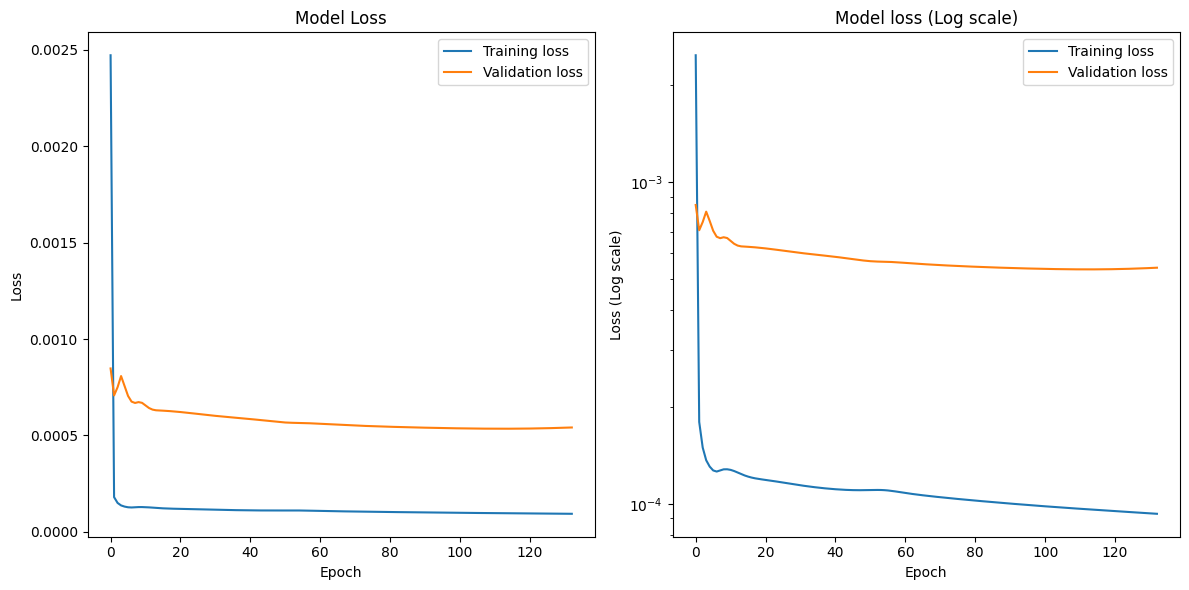

In [48]:
def plot_training_history(history):
  plt.figure(figsize = (12,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label = 'Training loss')
  plt.plot(history.history['val_loss'], label = 'Validation loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label = 'Training loss')
  plt.plot(history.history['val_loss'], label = 'Validation loss')
  plt.title('Model loss (Log scale)')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (Log scale)')
  plt.yscale('log')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_training_history(history)

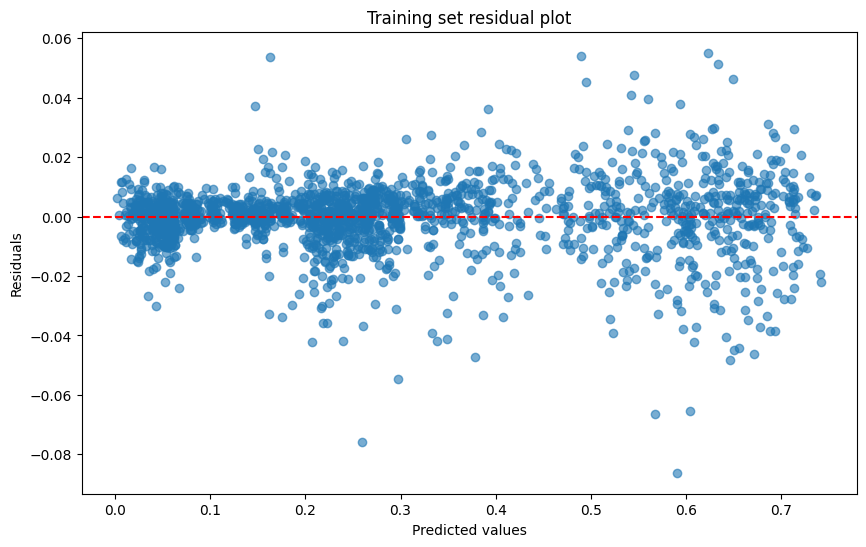

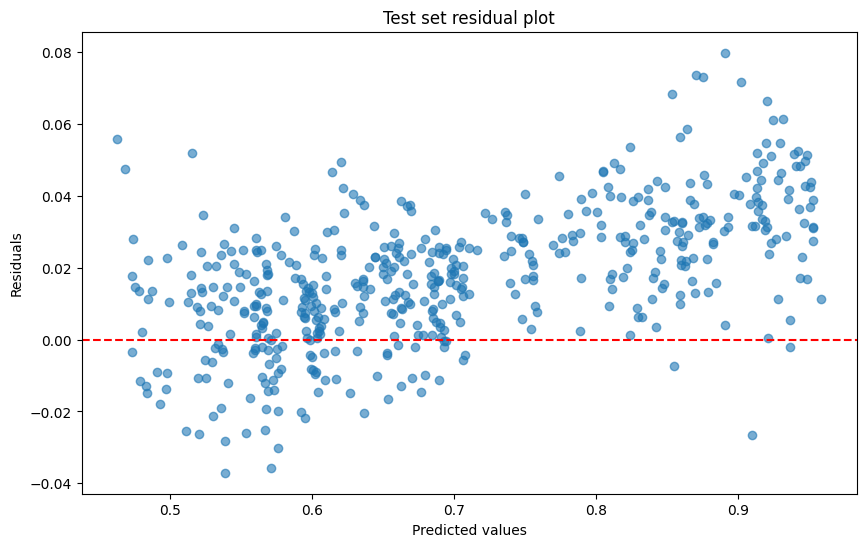

In [49]:
#function for residual plot:
def plot_residuals(y_true, y_pred, title = "Residual Plot"):
  residuals = y_true - y_pred
  plt.figure(figsize = (10, 6))
  plt.scatter(y_pred, residuals, alpha = 0.6)
  plt.title(title)
  plt.xlabel('Predicted values')
  plt.ylabel('Residuals')
  plt.axhline(y = 0, color = 'r', linestyle = '--')
  plt.show()

plot_residuals(y_train, y_train_pred, "Training set residual plot")
plot_residuals(y_test, y_test_pred, 'Test set residual plot')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


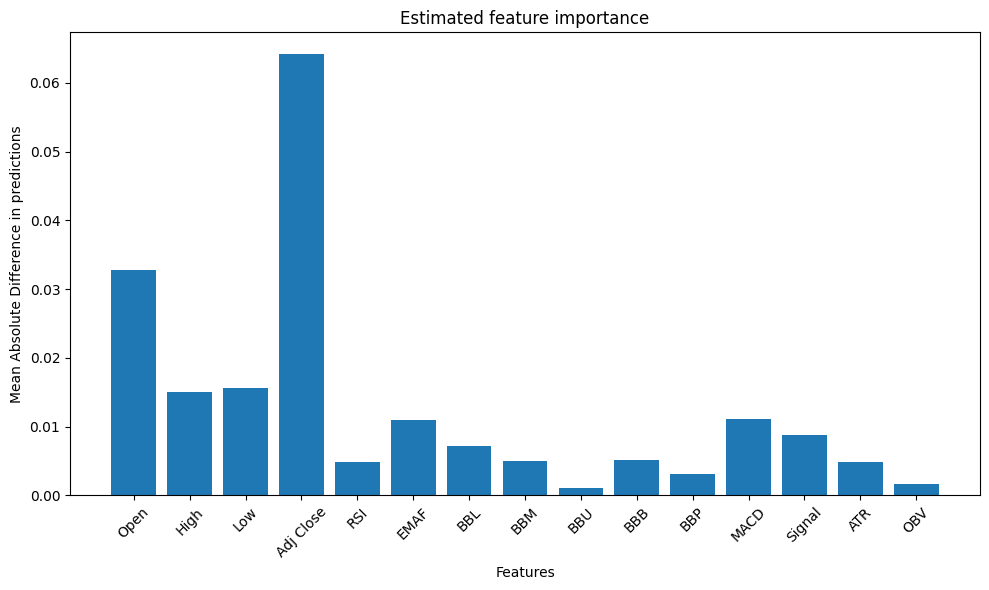

In [50]:
#estimating feature importance:
def estimate_feature_importance(model, X, feature_names):
  baseline_pred = model.predict(X)
  importance = []

  for i in range(X.shape[2]):
    X_permuted = X.copy()
    X_permuted[:,:,i] = np.random.permutation(X_permuted[:,:,i])
    permuted_pred = model.predict(X_permuted)
    importance.append(np.mean(np.abs(baseline_pred - permuted_pred)))

  plt.figure(figsize = (10,6))
  plt.bar(feature_names, importance)
  plt.title('Estimated feature importance')
  plt.xlabel('Features')
  plt.ylabel('Mean Absolute Difference in predictions')
  plt.xticks(rotation = 45)
  plt.tight_layout()
  plt.show()

#feature_names = ['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target']
feature_names = ['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'BBL',  'BBM',  'BBU',  'BBB',  'BBP', 'MACD', 'Signal', 'ATR', 'OBV']
estimate_feature_importance(model, X_test, feature_names)

#This is a rolling window approach that will evaluate the performance across different training sizes. It should give a better idea of how it will perform when predicting out of sample data.

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0018 - val_loss: 5.9726e-04
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4912e-04 - val_loss: 2.6948e-04
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3789e-04 - val_loss: 2.3330e-04
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0548e-04 - val_loss: 1.2045e-04
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0614e-05 - val_loss: 5.4487e-05
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4045e-05 - val_loss: 4.2489e-05
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6266e-05 - val_loss: 3.9595e-05
Epoch 8/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1574e-05 - val_loss: 4.2078e-05
Epoch 9/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8852e-05 - val_loss: 4.6931e-05
Epoch 10/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7467e-05 - val_loss: 5.2042e-05
Epoch 11/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 7, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 128)                 │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,109 (1.03 MB)

 Trainable params: 90,369 (353.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 180,740 (706.02 KB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0015 - val_loss: 7.2368e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6304e-04 - val_loss: 1.0204e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7546e-05 - val_loss: 4.7122e-05
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2195e-05 - val_loss: 1.9398e-05
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4386e-05 - val_loss: 1.2568e-05
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3506e-05 - val_loss: 9.0711e-06
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4094e-05 - val_loss: 1.1956e-05
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4517e-05 - val_loss: 2.1085e-05
Epoch 9/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4440e-05 - val_loss: 2.8045e-05
Epoch 10/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3806e-05 - val_loss: 2.9417e-05
Epoch 11/300
63/63 ━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 7, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 128)                 │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,109 (1.03 MB)

 Trainable params: 90,369 (353.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 180,740 (706.02 KB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 1/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0102 - val_loss: 2.7344e-04
Epoch 2/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3685e-04 - val_loss: 1.5227e-04
Epoch 3/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7880e-05 - val_loss: 1.4358e-04
Epoch 4/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8088e-05 - val_loss: 1.3428e-04
Epoch 5/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0501e-05 - val_loss: 1.2748e-04
Epoch 6/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5193e-05 - val_loss: 1.1651e-04
Epoch 7/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1767e-05 - val_loss: 1.1222e-04
Epoch 8/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9812e-05 - val_loss: 1.1901e-04
Epoch 9/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.8586e-05 - val_loss: 1.2864e-04
Epoch 10/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7798e-05 - val_loss: 1.3231e-04
Epoch 11/300
94/94 ━━━━━━━━━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 7, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 128)                 │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,109 (1.03 MB)

 Trainable params: 90,369 (353.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 180,740 (706.02 KB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0055 - val_loss: 2.7012e-04
Epoch 2/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6997e-04 - val_loss: 1.6498e-04
Epoch 3/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0905e-04 - val_loss: 1.5792e-04
Epoch 4/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0251e-04 - val_loss: 1.8228e-04
Epoch 5/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0382e-04 - val_loss: 2.0223e-04
Epoch 6/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0205e-04 - val_loss: 1.9909e-04
Epoch 7/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7034e-05 - val_loss: 1.9354e-04
Epoch 8/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2588e-05 - val_loss: 1.9841e-04
Epoch 9/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.0343e-05 - val_loss: 2.1420e-04
Epoch 10/300
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9782e-05 - val_loss: 2.3752e-04
Epoch 11/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 7, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 128)                 │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,109 (1.03 MB)

 Trainable params: 90,369 (353.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 180,740 (706.02 KB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0369 - val_loss: 0.0011
Epoch 2/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7217e-04 - val_loss: 8.9826e-04
Epoch 3/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.2325e-04 - val_loss: 7.6645e-04
Epoch 4/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9046e-04 - val_loss: 6.8501e-04
Epoch 5/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6713e-04 - val_loss: 6.3567e-04
Epoch 6/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5193e-04 - val_loss: 6.0702e-04
Epoch 7/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4304e-04 - val_loss: 5.9177e-04
Epoch 8/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3881e-04 - val_loss: 5.8268e-04
Epoch 9/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3738e-04 - val_loss: 5.7916e-04
Epoch 10/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3720e-04 - val_loss: 5.8173e-04
Epoch 11/300
1

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 7, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 128)                 │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,109 (1.03 MB)

 Trainable params: 90,369 (353.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 180,740 (706.02 KB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


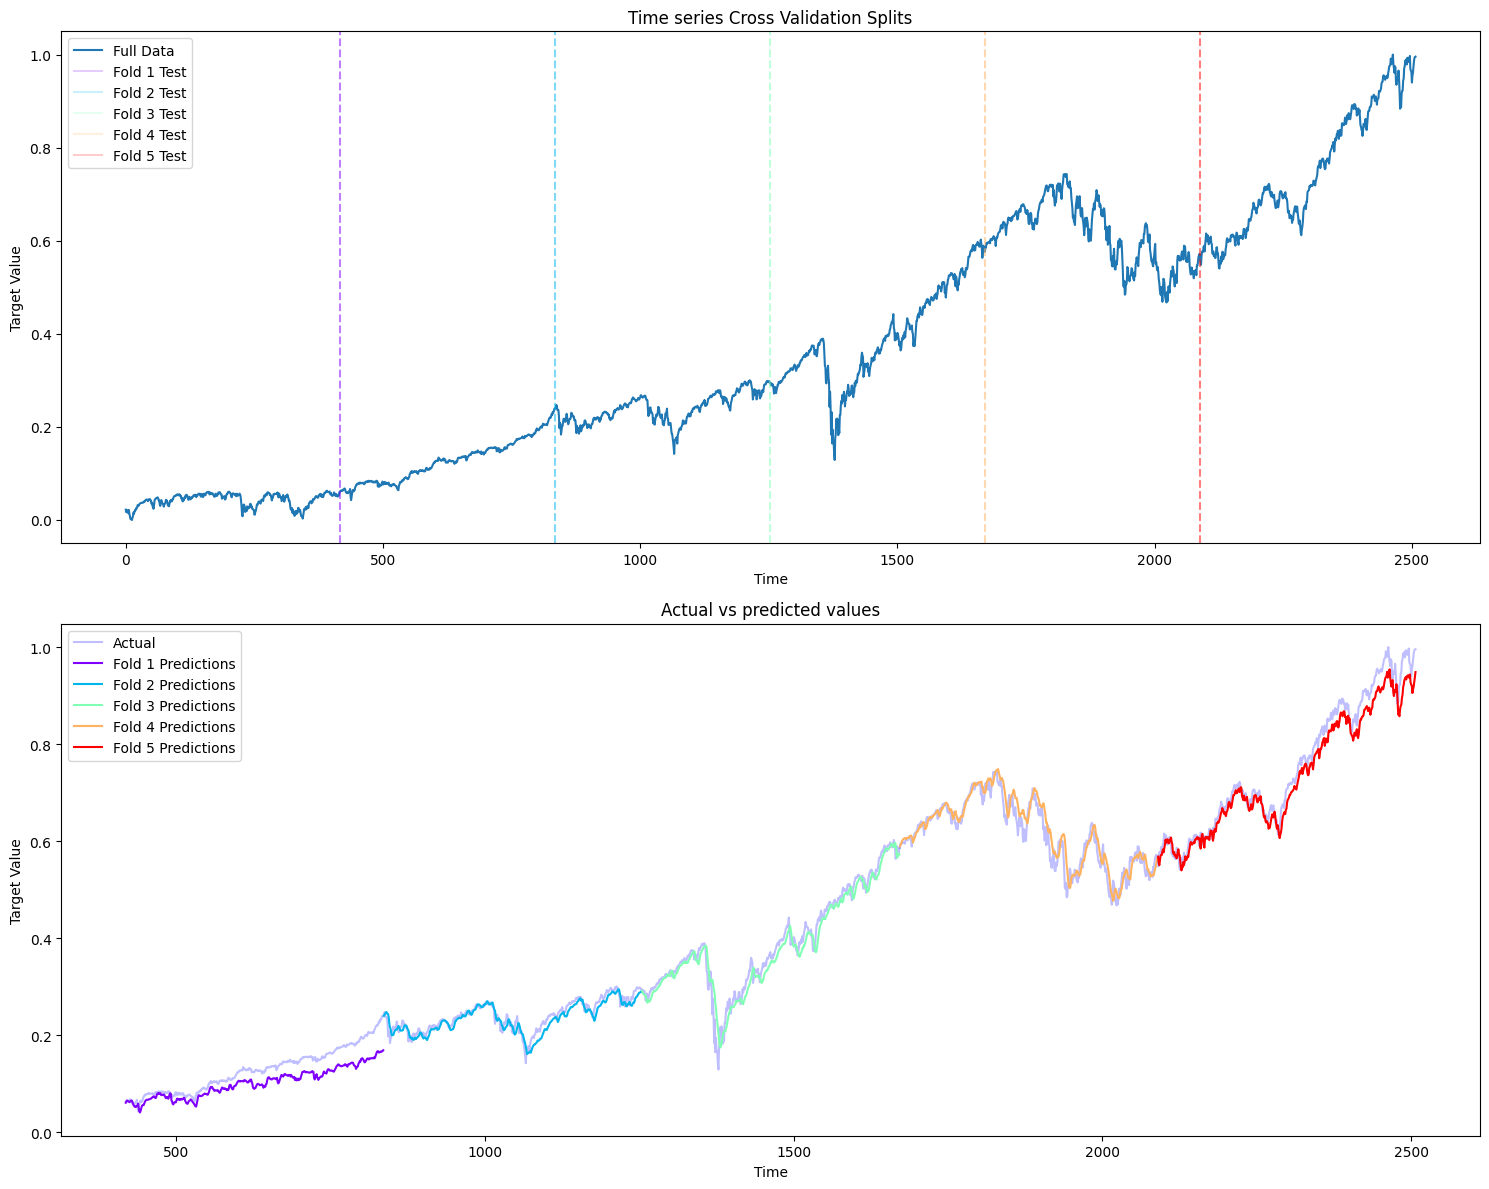

MSE - Mean: 0.0005, Std: 0.0003
RMSE - Mean: 0.0226, Std: 0.0062
MAE - Mean: 0.0180, Std: 0.0056
R2 - Mean: 0.8410, Std: 0.1481


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def time_series_cv_lstm(X, y, n_splits = 5, backcandles = 30, features = 9, lstm_units = 150, batch_size = 15, epochs = 30):
  tscv = TimeSeriesSplit(n_splits = n_splits)

  cv_scores = {
      'mse': [],
      'rmse': [],
      'mae': [],
      'r2': []
  }

  #prepare plots
  fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,12))
  colors =  plt.cm.rainbow(np.linspace(0,1, n_splits))

  #plot data and splits
  ax1.plot(range(len(y)), y, label='Full Data')
  ax1.set_title('Time series Cross Validation Splits')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Target Value')

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #plot splits
    ax1.axvline(x=train_index[-1], color = colors[fold], linestyle = '--', alpha = 0.5)
    ax1.axvline(train_index[-1], test_index[-1], alpha=0.2, color = colors[fold], label = f'Fold {fold+1} Test')

    #reset and recreate the model for each fold
    tf.keras.backend.clear_session()
    model, history = create_and_train_lstm(X_train, y_train, backcandles, features, lstm_units, batch_size, epochs)

    #make predictions
    y_pred = model.predict(X_test)

    #Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    #Store scores:
    cv_scores['mse'].append(mse)
    cv_scores['rmse'].append(rmse)
    cv_scores['mae'].append(mae)
    cv_scores['r2'].append(r2)

    #plot predictions
    ax2.plot(test_index, y_test, color = 'blue', alpha = 0.25, label = 'Actual' if fold == 0 else '')
    ax2.plot(test_index, y_pred, color = colors[fold], label = f'Fold {fold+1} Predictions')

  ax1.legend(loc = 'upper left')
  ax2.set_title('Actual vs predicted values')
  ax2.set_xlabel('Time')
  ax2.set_ylabel('Target Value')
  ax2.legend()
  plt.tight_layout()
  plt.show()

  #calculate mean and std scores:
  for metric in cv_scores:
    print(f'{metric.upper()} - Mean: {np.mean(cv_scores[metric]):.4f}, Std: {np.std(cv_scores[metric]):.4f}')

  return cv_scores, fig
#define n_splits, use all other previous hyperparamters
n_splits = 5
cv_scores, fig = time_series_cv_lstm(X,y,n_splits=5, backcandles=backcandles, features=features, lstm_units=lstm_units, batch_size=batch_size, epochs=epochs)

#Below is some additional cells for trying to get an actual price prediction. I will return to these once I get a better idea of how the training and base predictions are going